<a href="https://colab.research.google.com/github/sysyJEON/class_ai4ml/blob/main/ml_guide/ch07_KMeans_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 7.5 DBSCAN

### DBSCAN 개요

DBSCAN(Density Based Spatial Clustering of Applications with Noise)

: 특정 공간 내에 데이터 밀도 차이를 기반 알고리즘으로 하고 있어 복잡한 기하학적 분포도를 가진 데이터 세트에 대해서도 군집화를 잘 수행함

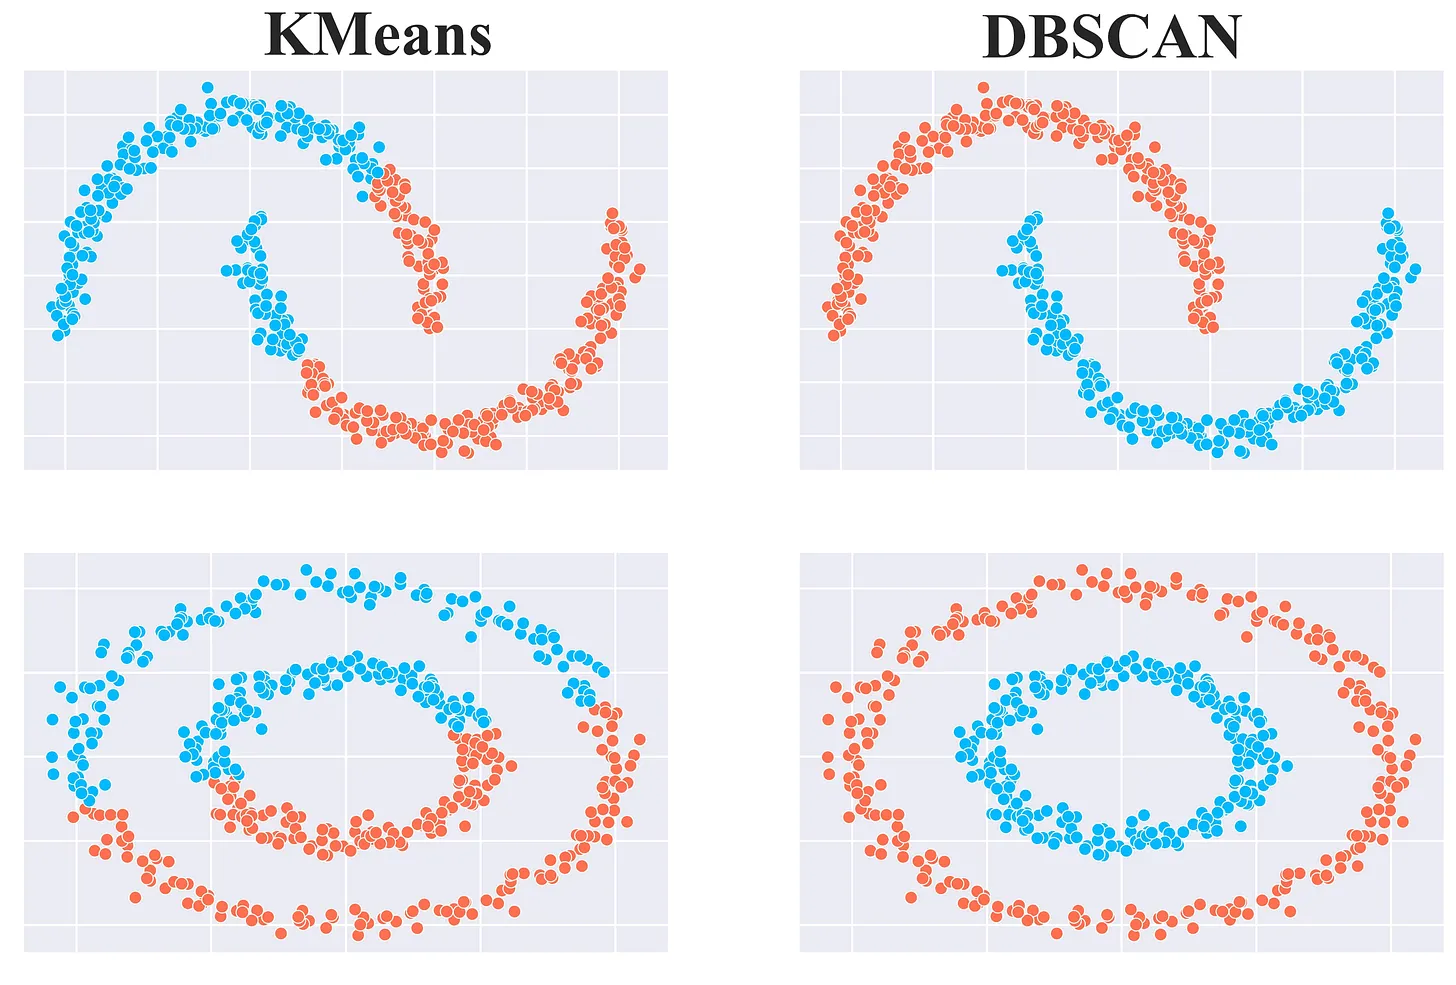

주요 파라미터
- 입실론 주변 영역(epsilon): 개별 데이터를 중심으로 입실론 반경을 가지는 원형의 영역
- 최소 데이터 개수(min points): 개별 데이터의 입실론 주변 영역에 포함되는 타 데이터의 개수

데이터 포인트
- 입실론 주변 영역 내에 포함되는 최소 데이터 개수를 충족시키는가 아닌가에 따라 다음과 같이 정의함
- 핵심 포인트(Core Point): 주변 영역 내에 최소 데이터 개수 이상의 타 데이터를 가지고 있을 경우 해당 데이터
- 이웃 포인트(Neighbor Point): 주변 영역 내에 위치한 타 데이터
- 경계 포인트(Border Point): 주변 영역 내에 최소 데이터 개수 이상의 아웃 포인트를 가지고 있지 않지만, 핵심 포인트를 이웃 포인트로 가지고 있는 데이터
- 잡음 포인트(Noise Point): 최소 데이터 개수 이상의 이웃 포인트를 가지고 있지 않으며, 핵심 포인트도 이웃 포인트로 가지고 있지 않는 데이터

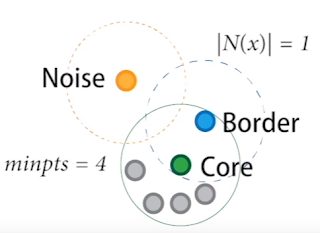

특정 입실론 반경 내에 포함될 최소 데이터 세트를 4개(자기 자신 포함)로 가정
- 핵심 포인트 p의 이웃 데이터 포인트 q 역시 핵심 포인트일 경우 p에서 q로 연결해 직접 접근 가능
- 특정 핵심 포인트에서 직접 접근이 가능한 다른 핵심 포인트를 서로 연결하면서 군집화 구성
- 이러한 방식으로 점차적으로 군집(Cluster) 영역을 확장해 나감

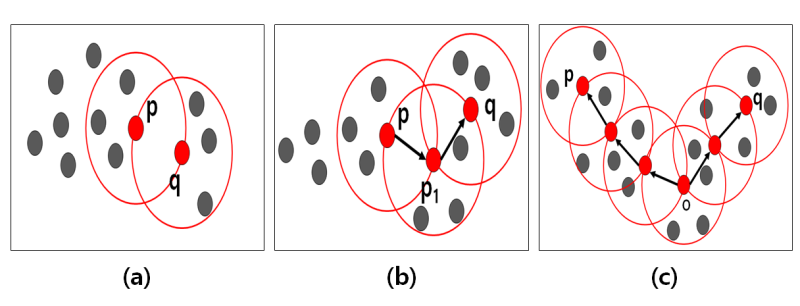

사이킷런의 `DBSCAN` 클래스 주요 파라미터
- `eps`: 입실론 주변 영역의 반경
- `min_samples`: 핵심 포인트가 되기 위해 입실론 주변 영역 내에 포함돼야 할 데이터의 최소 개수(자신의 데이터 포함, minpts + 1)

### DBSCAN 적용하기 – 붓꽃 데이터 세트

`DBSCAN` 클래스를 이용해 붓꽃 데이터 세트 군집화
- `eps=0.6, min_samples=8`
- 일반적으로 eps 값으로는 1 이하의 값을 설정

In [1]:
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

iris = load_iris()
feature_names = ['sepal_length','sepal_width','petal_length','petal_width']

# 보다 편리한 데이타 Handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target'] = iris.target

In [2]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

target  dbscan_cluster
0        0                49
        -1                 1
1        1                46
        -1                 4
2        1                42
        -1                 8
Name: count, dtype: int64


- dbscan_cluster -1: 노이즈에 속하는 군집
- 붓꽃 데이터 세트는 DBSCAN에서 0과 1 두 개의 군집으로 군집화됨
- DBSCAN은 군집의 개수를 알고리즘에 따라 자동으로 지정

DBSCAN으로 군집화 데이터 세트를 2차원 평면에 표현하기 위해 PCA를 이용해 2개의 피처로 압축 변환한 뒤, `visualize_cluster_plot()` 함수를 이용해 시각화

In [3]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

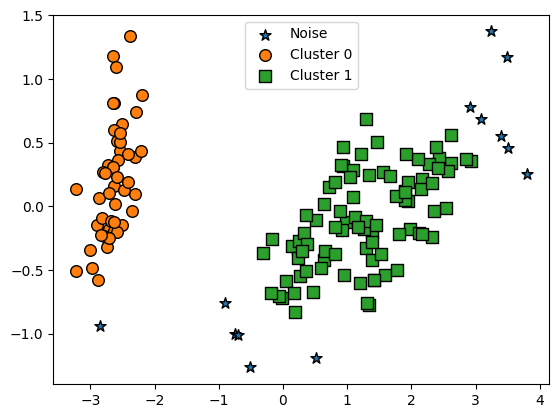

In [4]:
from sklearn.decomposition import PCA
# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(iris.data)
# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
irisDF['ftr1'] = pca_transformed[:,0]
irisDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 별표로 표현된 값은 모두 노이즈
- PCA로 2차원으로 표현하면 이상치인 노이즈 데이터가 명확히 드러남

적절한 eps와 min_samples 파라미터를 통해 최적의 군집을 찾는 게 중요
- eps 값 크게 -> 반경 커짐 -> 포함하는 데이터 많아짐 -> 노이즈 데이터 개수 작아짐
- min_samples 크게 -> 주어진 반경 내에서 더 많은 데이터 포함시켜야 함 -> 노이즈 데이터 개수 커짐

예제) eps를 기존의 0.6에서 0.8로 증가시키면 노이즈 데이터 수가 줄어든다.

target  dbscan_cluster
0        0                50
1        1                50
2        1                47
        -1                 3
Name: count, dtype: int64


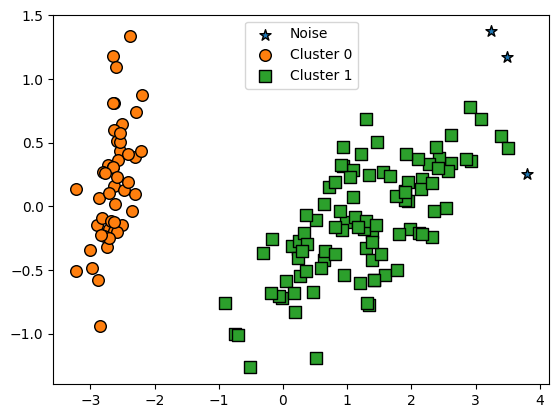

In [5]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 노이즈 군집인 -1이 3개밖에 없음
- 기존 eps=6일 때 노이즈로 분류된 데이터 세트는 eps 반경이 커지면서 Cluster 1에 소속됨

예제) eps를 기존 0.6으로 유지하고 min_samples를 16으로 늘려보기

target  dbscan_cluster
0        0                48
        -1                 2
1        1                44
        -1                 6
2        1                36
        -1                14
Name: count, dtype: int64


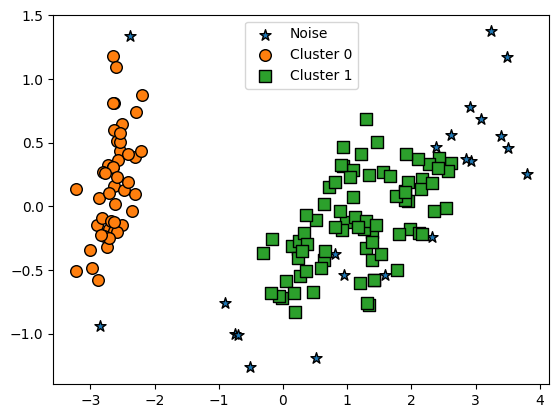

In [6]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(iris.data)

irisDF['dbscan_cluster'] = dbscan_labels
irisDF['target'] = iris.target

iris_result = irisDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(iris_result)

visualize_cluster_plot(dbscan, irisDF, 'dbscan_cluster', iscenter=False)

- 노이즈 데이터가 기존보다 많이 증가함

### DBSCAN 적용하기 – make_circles() 데이터 세트

복잡한 기하학적 분포를 가지는 데이터 세트에서 DBSCAN과 타 알고리즘을 비교하기

`make_circles()` 함수를 이용해 내부 원과 외부 원 형태로 돼 있는 2차원 데이터 세트 만들기
- `noise`: 노이즈 데이터 세트의 비율
- `factor`: 외부 원과 내부 원의 scale 비율

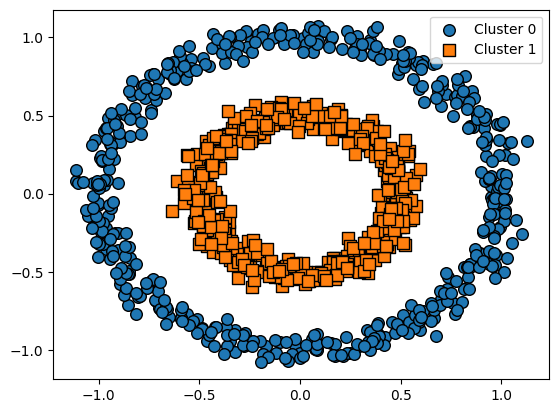

In [7]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=0, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

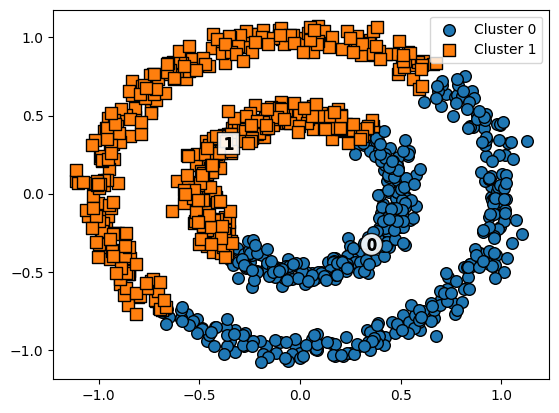

In [8]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행.
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

- 위, 아래 군집 중심을 기반으로 위와 아래 절반으로 군집화됨
- 거리 기반 군집화로는 위와 같이 데이터가 특정한 형태로 지속해서 이어지는 부분을 찾아내기 어려움

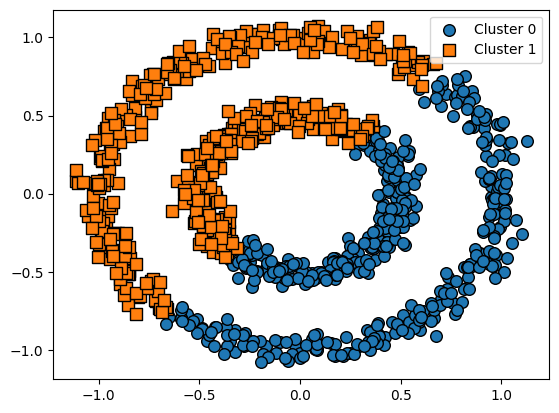

In [9]:
# GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행.
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

- 군집화가 원하는 방향으로 되지 않음

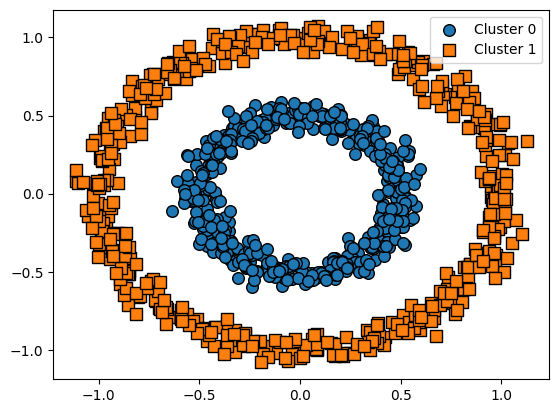

In [10]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행.
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)

- 원하는 방향으로 정확히 군집화가 됐음

# 7.6 군집화 실습 - 고객 세그먼테이션

### 고객 세그먼테이션의 정의와 기법

고객 세그먼테이션(Customer Segmentation): 다양한 기준으로 고객을 분류하는 기법

기본적인 고객 분석 요소인 RFM 기법 이용
- RECENCY (R): 가장 최근 상품 구입 일에서 오늘까지의 기간
- FREQUENCY (F): 상품 구매 횟수
- MONETARY VALUE (M): 총 구매 금액

### 데이터 세트 로딩과 데이터 클렌징

데이터 세트: http://archive.ics.uci.edu/ml/datasets/online+retail

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='/content/drive/MyDrive/데이터/Online Retail.xlsx')
retail_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


- 제품 주문 데이터 세트
- InvoiceNo: 주문번호, 'C'로 시작하는 것은 취소 주문
- StockCode: 제품 코드
- Description: 제품 설명
- Quantity: 주문 제품 건수
- InvoiceDate: 주문 일자
- UnitPrice: 제품 단가
- CustomerID: 고객 번호
- Country: 국가명(주문 고객의 국적)

In [13]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


- 전체 데이터 541,909개
- CustomerID의 Null 값이 너무 많음
- 다른 칼럼의 경우도 오류 데이터 존재

사전 정제 작업 피요
- Null 데이터 제거: 특히 CustomerID가 Null인 데이터가 많음. 고객 세그먼테이션에서 고객 식별 번호가 없는 데이터는 필요가 없기에 삭제
- 오류 데이터 삭제: 대표적인 오류 데이터는 Quantity 또는 UnitPrice가 0보다 작은 경우. Quantity가 0보다 작은 경우는 반환을 뜻하는 값. 이 경우 InvocieNo의 앞자리는 'C'임. 분석의 효율성을 위해 이 데이터는 모두 삭제

In [14]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


- 전체 데이터가 541,909에서 397,884로 줄었음
- Null 값 없음

In [15]:
retail_df['Country'].value_counts()[:5]

,count
Country,
United Kingdom,354321
Germany,9040
France,8341
EIRE,7236
Spain,2484


영국이 대다수를 차지하므로 다른 국가의 데이터는 모두 제외

In [16]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


- 최종 데이터는 354,321건으로 줄었음

### RFM 기반 데이터 가공

'UnitPrice'와 'Quantity'를 곱해서 주문 금액의 데이터 만들기

CustomerNo 편리한 식별성을 위해 float형을 int형으로 변경

In [17]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

Top-5 주문 건수와 주문 금액을 가진 고객 데이터 추출

In [18]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

CustomerID
17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: count, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


온라인 판매 데이터 세트는 전형적인 판매 데이터 세트와 같이 주문번호(InvocieNo) + 상품코드(StockCode) 레벨의 식별자로 돼 있음
- InvoiceNo + StockCode로 Group by를 수행하면 거의 1에 가깝게 유일한 식별자 레벨이 됨

In [19]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

RFM 기반 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문 횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것
- 주문번호 + 상품코드 기준의 데이터를 고객 기준의 Recency, Frequency, Monetary value 데이터로 변경
- 이를 위해 주문번호 기준의 데이터를 개별 고객 기준의 데이터로 Group by 해야 함

여러 개의 칼럼에 서로 다른 aggregation 연산 수행하기 위해 DataFrameGroupby 객체에 `agg()` 이용
- Frequency: 고객별 주문 건수 -> CustomerID로 groupby()해서 InvoiceNo의 count() aggregation으로 구함
- Moneytary value: 고객별 주문 금액 -> CustomerID로 groupby()해서 sale_amount의 sum() aggregation으로 구함
- Recency: 가장 최근 상품 구입 일에서 오늘까지의 기간 -> CustomerID로 groupby()해서 InvoiceDate 칼럼의 max()로 고객별 가장 최근 주문 일자를 먼저 구한 뒤 추후에 가공 작업 별도 수행

In [20]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


Recency
- 가장 최근 상품 구입 일에서 오늘까지의 기간
- 오늘 날짜를 기준으로 가장 최근 주문일자를 뺀 날짜
- 온라인 판매 데이터가 2010년 12월 1일 ~ 2011년 12월 9일까지
- 오늘 날짜는 2011뇬 12월 10일을 현재 날짜로 간주하고 가장 최근의 주문 일자를 뺀 데이터에서 일자 데이터(days)만 추출해 생성

In [21]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션

온라인 판매 데이터 세트는 소매업체의 대규모 주문을 포함하고 있어 주문 횟수와 주문 금액에서 개인 고객 주문과 매우 큰 차이를 나타냄

-> 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상 발생

'Recency', 'Frequency', 'Monetary' 칼럼 값 분포 히스토그램을 확인

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

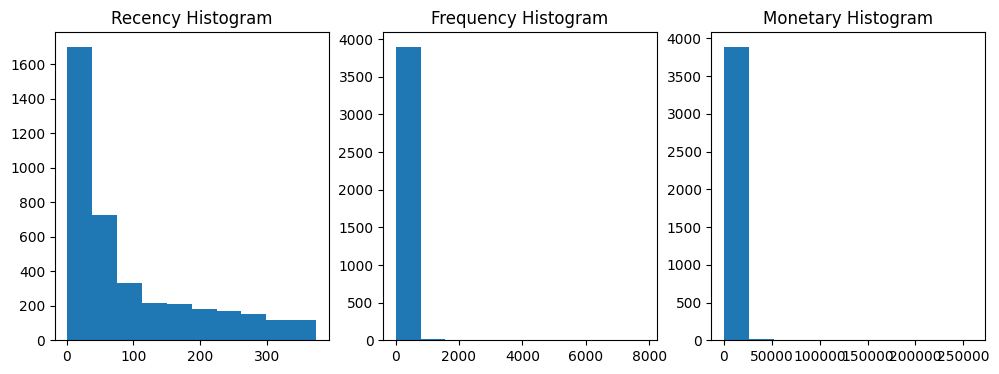

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

- 모두 왜곡된 데이터 값 분포도를 가짐

각 칼럼의 데이터 값 백분위로 대략적으로 어떻게 값이 분포돼 있는지 확인

In [23]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


- Recency는 평균이 92.7이지만 50%인 51보다 크게 높음
- max 값은 374로 75%인 143보다 훨씬 커서 왜곡 정도가 높음

왜곡 정도가 매우 높은 데이터 세트에 K-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨

데이터 세트를 `StandardScaler`로 평균과 표준편차를 재조정한 뒤 K-평균 수행

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.576


- 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.576로 안정적인 수치가 나옴

각 군집별 실루엣 계수 값 확인
- 군집 개수를 2~5개까지 변화시키면서 개별 군집의 실루엣 계수 값과 데이터 구성 알아보기

In [25]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [26]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

<ipython-input-26-84edf3406851>:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
<ipython-input-26-84edf3406851>:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


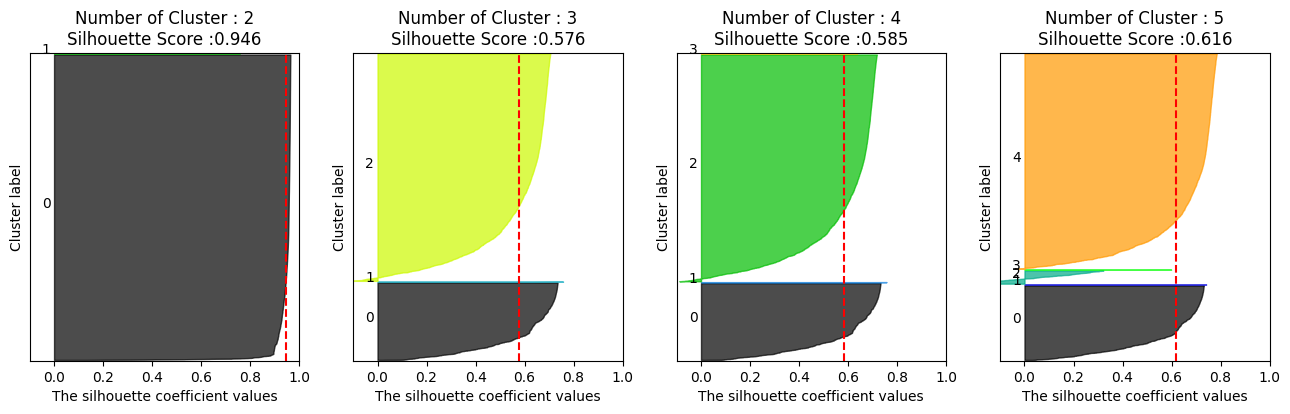

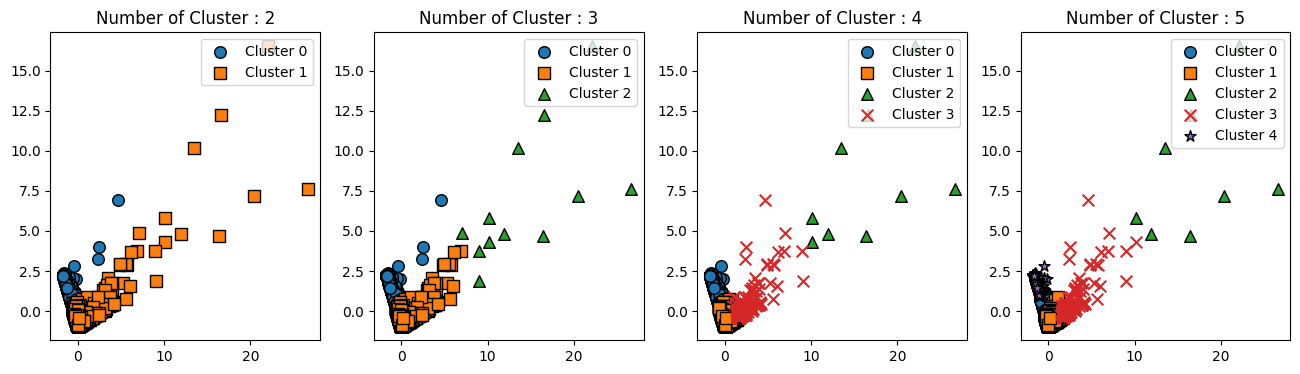

In [27]:
visualize_silhouette([2,3,4,5],X_features_scaled) # 군집 개수를 2~5개까지 변화시키기
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

- 데이터 세트 개수가 너무 작은 군집이 만들어짐
- 군집이 3개 이상일 때부터는 실루엣 계수 역시 상대적으로 매우 작음
- 군집 내부에서도 데이터가 광범위하게 퍼져 있음
- 소수의 데이터 세트는 앞에서 왜곡된 데이터 값인 특정 소매점의 대량 주문 구매 데이터임

데이터 세트의 왜곡 정도 낮추기 위해 로그 변환 적용한 뒤 K-평균 알고리즘 적용

In [28]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.303


- 실루엣 스코어는 로그 변환하기 전보다 떨어짐
- 실루엣 스코어 절대치보다 개별 군집이 균일하게 나뉘어 지는 것이 더 중요

로그 변환한 데이터 세트를 기반으로 실루엣 계수와 군집화 구성 시각화

<ipython-input-26-84edf3406851>:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
<ipython-input-26-84edf3406851>:36: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\


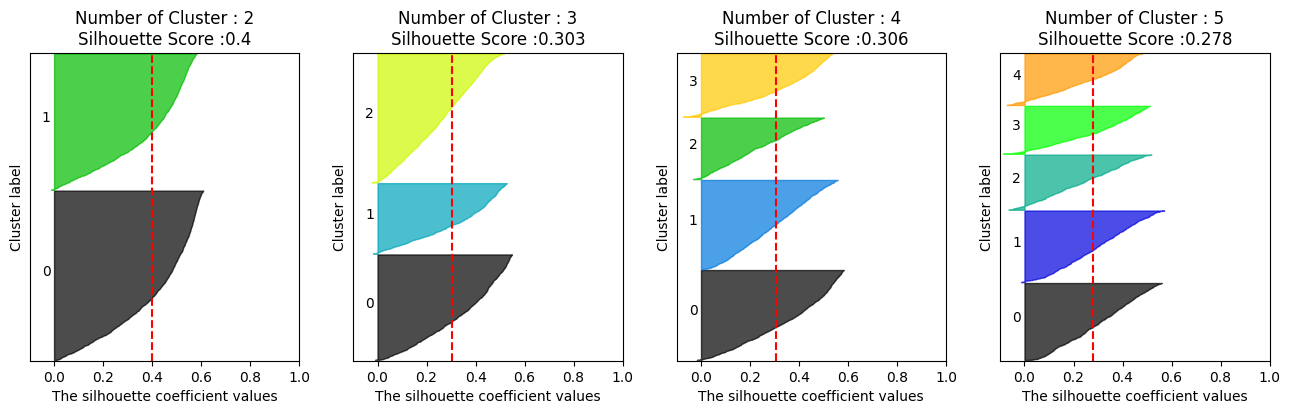

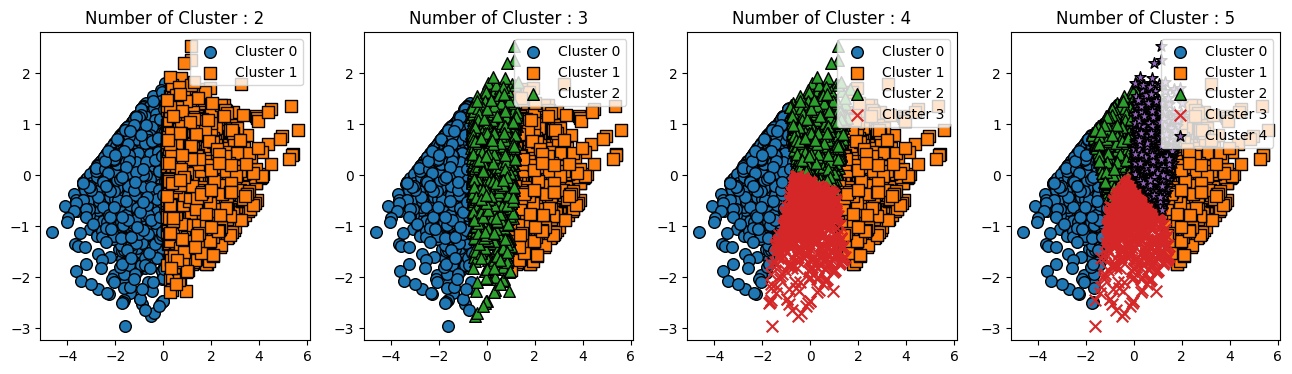

In [29]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

- 실루엣 스코어는 떨어지지만 더 균일하게 군집화가 구성됨